#  Topic Classification with a Feedforward Network




The goal of this project is to develop a Feedforward neural network for topic classification. 



For that purpose, I've implemented:

- Text processing methods for transforming raw text data into input vectors for the network


- A Feedforward network consisting of:
    - **One-hot** input layer mapping words into an **Embedding weight matrix**
    - **One hidden layer** computing the mean embedding vector of all words in input followed by a **ReLU activation function**
    - **Output layer** with a **softmax** activation.


- The Stochastic Gradient Descent (SGD) algorithm with **back-propagation** to learn the weights of the Neural network. The algorithm:
    - Uses (and minimise) the **Categorical Cross-entropy loss** function
    - Performs a **Forward pass** to compute intermediate outputs
    - Performs a **Backward pass** to compute gradients and update all sets of weights
    - Implements and uses **Dropout** after each hidden layer for regularisation





- I've re-trained the network by using pre-trained embeddings ([GloVe](https://nlp.stanford.edu/projects/glove/)) trained on large corpora.



### Data 

The data that I've used for the task is a subset of the [AG News Corpus](http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html) and it can be found in the `./data_topic` folder in CSV format:

- `data_topic/train.csv`: contains 2,400 news articles, 800 for each class to be used for training.
- `data_topic/dev.csv`: contains 150 news articles, 50 for each class to be used for hyperparameter selection and monitoring the training process.
- `data_topic/test.csv`: contains 900 news articles, 300 for each class to be used for testing.




In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random
from time import localtime, strftime
from scipy.stats import spearmanr,pearsonr
import zipfile
import gc

# fixing random seed for reproducibility
random.seed(123)
np.random.seed(123)


## Transform Raw texts into training and development data



In [2]:
#Loading the training,development and test dataset
train_data = pd.read_csv('train.csv')
dev_data = pd.read_csv('dev.csv')
test_data = pd.read_csv('test.csv')

In [3]:
#Renaming the columns of the dataframe
train_data.columns = ['label','text']
dev_data.columns = ['label','text']
test_data.columns = ['label','text']

In [4]:
train_data

,label,text
0,1,Reuters - South Korean police used water canno...
1,1,Reuters - Thousands of Palestinian\prisoners i...
2,1,AFP - Sporadic gunfire and shelling took place...
3,1,AP - Dozens of Rwandan soldiers flew into Suda...
4,1,Reuters - Rwandan troops were airlifted on Sun...
...,...,...
2394,3,"Australia #39;s dominant airline, Qantas, has ..."
2395,3,Reuters - Medtronic Inc. (MDT.N) on Wednesday\...
2396,3,SAN FRANCISCO (Reuters) - Google Inc. &lt;A H...
2397,3,"BHP Billiton, the world #39;s biggest mining c..."


In [5]:
train_data['text'][0]

'Reuters - South Korean police used water cannon in\\central Seoul Sunday to disperse at least 7,000 protesters\\urging the government to reverse a controversial decision to\\send more troops to Iraq.'

In [6]:
#creating different text lists for training,development and test datasets

train_text_list = [train_data['text'][i].lower() for i in range(0,len(train_data['text']))]
dev_text_list = [dev_data['text'][i].lower() for i in range(0,len(dev_data['text']))]
test_text_list = [test_data['text'][i].lower() for i in range(0,len(test_data['text']))]

#creating different label arrays for training,development and test datasets

train_label_array = train_data['label'].values
dev_label_array = dev_data['label'].values
test_label_array = test_data['label'].values

In [7]:
train_text_list

['reuters - south korean police used water cannon in\\central seoul sunday to disperse at least 7,000 protesters\\urging the government to reverse a controversial decision to\\send more troops to iraq.',
 "reuters - thousands of palestinian\\prisoners in israeli jails began a hunger strike for better\\conditions sunday, but israel's security minister said he\\didn't care if they starved to death.",
 'afp - sporadic gunfire and shelling took place overnight in the disputed georgian region of south ossetia in violation of a fragile ceasefire, wounding seven georgian servicemen.',
 "ap - dozens of rwandan soldiers flew into sudan's troubled darfur region sunday, the first foreign armed force deployed in the area since arab militiamen began a rampage against black african farmers, killing thousands.",
 "reuters - rwandan troops were airlifted on sunday\\to sudan's darfur as the first foreign force there, mandated to\\protect observers monitoring a cease-fire between the sudanese\\governmen

In [8]:
np.unique(test_label_array)

array([1, 2, 3], dtype=int64)

# Create input representations


To train the Feedforward network, we first need to obtain input representations given a vocabulary. One-hot encoding requires large memory capacity. Therefore, we will instead represent documents as lists of vocabulary indices (each word corresponds to a vocabulary index). 


## Text Pre-Processing Pipeline

To obtain a vocabulary of words. I've followed the below steps: 
- tokenise all texts into a list of unigrams (tip: you can re-use the functions from Assignment 1) 
- remove stop words (using the one provided or one of your preference) 
- remove unigrams appearing in less than K documents
- use the remaining to create a vocabulary of the top-N most frequent unigrams in the entire corpus.


In [9]:
#Chosen list of stopwords

stop_words = ['a','in','on','at','and','or', 
              'to', 'the', 'of', 'an', 'by', 
              'as', 'is', 'was', 'were', 'been', 'be', 
              'are','for', 'this', 'that', 'these', 'those', 'you', 'i', 'if',
             'it', 'he', 'she', 'we', 'they', 'will', 'have', 'has',
              'do', 'did', 'can', 'could', 'who', 'which', 'what',
              'but', 'not', 'there', 'no', 'does', 'not', 'so', 've', 'their',
             'his', 'her', 'they', 'them', 'from', 'with', 'its']


### Unigram extraction from a document

I've implemented the `extract_ngrams` function. It takes as input:
- `x_raw`: a string corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `vocab`: a given vocabulary. It should be used to extract specific features.

and returns:

- a list of all extracted features.


In [10]:
def extract_ngrams(x_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', 
                   stop_words=[], vocab=set()):
    
    x=[]
    stop_words = ['a','in','on','at','and','or', 
              'to', 'the', 'of', 'an', 'by', 
              'as', 'is', 'was', 'were', 'been', 'be', 
              'are','for', 'this', 'that', 'these', 'those', 'you', 'i', 'if',
             'it', 'he', 'she', 'we', 'they', 'will', 'have', 'has',
              'do', 'did', 'can', 'could', 'who', 'which', 'what',
              'but', 'not', 'there', 'no', 'does', 'not', 'so', 've', 'their',
             'his', 'her', 'they', 'them', 'from', 'with', 'its']

    
    empty_list = []
    
    x_raw = x_raw.lower() #converting the string to lower case
    
    tokenizer = re.compile(token_pattern)
    
    x_raw = re.sub(r'[^a-zA-Z0-9\s]', ' ', x_raw) #executing the regex on the given string
    
    
    
    words = [w for w in tokenizer.findall(x_raw, ) if w not in stop_words] #extracting unigrams
    
    if(ngram_range[0]==1):
        x=words
    
    for j in range(ngram_range[0],ngram_range[1]+1):     # Here we are extracting n-grams as a list within list
        
        if(j==1):
            continue
        
        temp = zip(*[words[i:] for i in range(j)])
        temp_list = [" ".join(t) for t in temp]
        empty_list.append(temp_list)
    
    for item in empty_list: # Here we are creating a single list of n-grams from above
        
        for m in item:
            x.append(m) 
        
    
    vocab_len = len(vocab) # While extracting n-grams of dev and test text list, we should include only those words that are in the vocabulary
    if(vocab_len>0):
        x=[items for items in x if item in list(vocab)]
    
    
        
    return x
    
    







In [11]:
res = extract_ngrams('This is 123 very good. I like it.', ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', 
                   stop_words=[], vocab=set())
print(res)

['very', 'good', 'like', 'very good', 'good like', 'very good like']


### Create a vocabulary of n-grams

Then the `get_vocab` function will be used to (1) create a vocabulary of ngrams; (2) count the document frequencies of ngrams; (3) their raw frequency. It takes as input:
- `X_raw`: a list of strings each corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `min_df`: keep ngrams with a minimum document frequency.
- `keep_topN`: keep top-N more frequent ngrams.

and returns:

- `vocab`: a set of the n-grams that will be used as features.
- `df`: a Counter (or dict) that contains ngrams as keys and their corresponding document frequency as values.
- `ngram_counts`: counts of each ngram in vocab


In [12]:
def get_vocab(X_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', 
              min_df=0, keep_topN=0, 
              stop_words=[]):
    
    vocab = set()
    vocab_list=[]
    df = Counter()
    ngram_counts = Counter()
    
    
    
    for txt in X_raw:          # getting the unigram list for a given list of texts
        
        ngrams_list = extract_ngrams(txt, ngram_range=ngram_range, token_pattern=token_pattern,  
                   stop_words=stop_words)  # getting the unigram list for a given text
        
        #updating document and unigram frequencies and storing them as dictionary
        
        df.update(list(set(ngrams_list)))  
        ngram_counts.update(ngrams_list)   
        
    
    for item in df:
        
        if(df[item]>=min_df):
            
            vocab_list.append(item)
        
    vocab = set(vocab_list)  # only adding those unigram to the vocabulary, whose document frequency is equal to or greater than a certain value 
    
    if(keep_topN>0):
        vocab = set(tmp[0] for tmp in ngram_counts.most_common(keep_topN) if tmp[0] in vocab) # only keeping top-N most frequent unigram
        
        
    
        
    
    
    
    
    return vocab, df, ngram_counts

In [13]:
str_list = ['This is good,and this is very good','This is a good animal','I read poetry']
vocab,df, ngram_counts = get_vocab(str_list, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', 
              min_df=0, keep_topN=3, 
              stop_words=[])
vocab

{'good', 'good very', 'very'}

In [14]:
ngram_counts

Counter({'good': 3,
         'very': 1,
         'good very': 1,
         'very good': 1,
         'good very good': 1,
         'animal': 1,
         'good animal': 1,
         'read': 1,
         'poetry': 1,
         'read poetry': 1})

In [15]:
d= Counter(a=200,b=1,c=90,d=78,e=45)
for t in d.most_common(2):
    
    print(t[0])

a
c


Now you should use `get_vocab` to create your vocabulary and get document and raw frequencies of unigrams:

In [16]:
vocab,df,ngram_counts = get_vocab(train_text_list, ngram_range=(1,1), 
              min_df=0, 
              stop_words=stop_words) #forming the vocabulary with the texts in the training list

In [17]:
vocab

{'hitter',
 'violation',
 'seat',
 'enter',
 'bowe',
 'suspend',
 'widespread',
 'applications',
 'bruce',
 'lend',
 'ultimate',
 'border',
 'iii',
 'uhf',
 'wattage',
 'daniela',
 'supermarket',
 'anybody',
 'germany',
 'connection',
 'reached',
 'tzuba',
 'smattering',
 'underlings',
 'front',
 'fuse',
 'rolls',
 'smug',
 'natural',
 'disturbing',
 'impact',
 'buried',
 'charles',
 'operations',
 'corner',
 'hotline',
 'long',
 'scoffed',
 'owners',
 'welterweight',
 'nymex',
 'deflating',
 'containing',
 'hussein',
 'battled',
 'dominican',
 'chapel',
 'oust',
 'blowers',
 'violate',
 'together',
 'golf',
 'distributed',
 'toughest',
 'lowering',
 'heavily',
 'showcase',
 'understands',
 'denmark',
 'levelled',
 'nigeria',
 'skiing',
 'uniting',
 'jennings',
 'gear',
 'golfers',
 'drafty',
 'yu',
 'pest',
 'impoverished',
 'channel',
 'unlucky',
 'proceedings',
 'partnership',
 'proper',
 'doubles',
 'estimate',
 'gq',
 'flanagan',
 'meets',
 'jersey',
 'servant',
 'cto',
 'newmarch

Then, I've created vocabulary id -> word and word -> vocabulary id dictionaries for reference:

In [18]:
vocab_word_to_id = {}
vocab_id_to_word = {}

# creating and devoloping two dictonaries to store vocab word as key and its index as value and vice-versa

for i in range(len(vocab)):
    vocab_word_to_id[list(vocab)[i]] = i
    vocab_id_to_word[i] = list(vocab)[i]

In [19]:
vocab_word_to_id

{'hitter': 0,
 'violation': 1,
 'seat': 2,
 'enter': 3,
 'bowe': 4,
 'suspend': 5,
 'widespread': 6,
 'applications': 7,
 'bruce': 8,
 'lend': 9,
 'ultimate': 10,
 'border': 11,
 'iii': 12,
 'uhf': 13,
 'wattage': 14,
 'daniela': 15,
 'supermarket': 16,
 'anybody': 17,
 'germany': 18,
 'connection': 19,
 'reached': 20,
 'tzuba': 21,
 'smattering': 22,
 'underlings': 23,
 'front': 24,
 'fuse': 25,
 'rolls': 26,
 'smug': 27,
 'natural': 28,
 'disturbing': 29,
 'impact': 30,
 'buried': 31,
 'charles': 32,
 'operations': 33,
 'corner': 34,
 'hotline': 35,
 'long': 36,
 'scoffed': 37,
 'owners': 38,
 'welterweight': 39,
 'nymex': 40,
 'deflating': 41,
 'containing': 42,
 'hussein': 43,
 'battled': 44,
 'dominican': 45,
 'chapel': 46,
 'oust': 47,
 'blowers': 48,
 'violate': 49,
 'together': 50,
 'golf': 51,
 'distributed': 52,
 'toughest': 53,
 'lowering': 54,
 'heavily': 55,
 'showcase': 56,
 'understands': 57,
 'denmark': 58,
 'levelled': 59,
 'nigeria': 60,
 'skiing': 61,
 'uniting': 62,

In [20]:
vocab_id_to_word

{0: 'hitter',
 1: 'violation',
 2: 'seat',
 3: 'enter',
 4: 'bowe',
 5: 'suspend',
 6: 'widespread',
 7: 'applications',
 8: 'bruce',
 9: 'lend',
 10: 'ultimate',
 11: 'border',
 12: 'iii',
 13: 'uhf',
 14: 'wattage',
 15: 'daniela',
 16: 'supermarket',
 17: 'anybody',
 18: 'germany',
 19: 'connection',
 20: 'reached',
 21: 'tzuba',
 22: 'smattering',
 23: 'underlings',
 24: 'front',
 25: 'fuse',
 26: 'rolls',
 27: 'smug',
 28: 'natural',
 29: 'disturbing',
 30: 'impact',
 31: 'buried',
 32: 'charles',
 33: 'operations',
 34: 'corner',
 35: 'hotline',
 36: 'long',
 37: 'scoffed',
 38: 'owners',
 39: 'welterweight',
 40: 'nymex',
 41: 'deflating',
 42: 'containing',
 43: 'hussein',
 44: 'battled',
 45: 'dominican',
 46: 'chapel',
 47: 'oust',
 48: 'blowers',
 49: 'violate',
 50: 'together',
 51: 'golf',
 52: 'distributed',
 53: 'toughest',
 54: 'lowering',
 55: 'heavily',
 56: 'showcase',
 57: 'understands',
 58: 'denmark',
 59: 'levelled',
 60: 'nigeria',
 61: 'skiing',
 62: 'uniting',

### Convert the list of unigrams  into a list of vocabulary indices

Storing actual one-hot vectors into memory for all words in the entire data set is prohibitive. Instead, we will store word indices in the vocabulary and look-up the weight matrix. This is equivalent of doing a dot product between an one-hot vector and the weight matrix. 

First, the documents in train, dev and test sets are represented as lists of words in the vocabulary:

In [21]:
train_uni = []
dev_uni = []
test_uni = []

# converting the texts in the training, development and test list to a list of corresponding words in the vocabulary

for i in range(len(train_text_list)):
    ngram = extract_ngrams(train_text_list[i], (1,1),r'\b[A-Za-z][A-Za-z]+\b', 
                   stop_words)
    train_uni.append(ngram)

for i in range(len(dev_text_list)):
    ngram = extract_ngrams(dev_text_list[i], (1,1),r'\b[A-Za-z][A-Za-z]+\b', 
                   stop_words)
    dev_uni.append(ngram)

for i in range(len(test_text_list)):
    ngram = extract_ngrams(test_text_list[i], (1,1),r'\b[A-Za-z][A-Za-z]+\b', 
                   stop_words)
    test_uni.append(ngram) 

In [22]:
test_uni

[['ap',
  'man',
  'claims',
  'gov',
  'james',
  'mcgreevey',
  'sexually',
  'harassed',
  'him',
  'pushing',
  'cash',
  'settlement',
  'up',
  'million',
  'before',
  'governor',
  'decided',
  'announce',
  'gay',
  'had',
  'extramarital',
  'affair',
  'sources',
  'told',
  'associated',
  'press'],
 ['najaf',
  'iraq',
  'explosions',
  'gunfire',
  'rattled',
  'through',
  'city',
  'najaf',
  'troops',
  'armored',
  'vehicles',
  'tanks',
  'rolled',
  'back',
  'into',
  'streets',
  'here',
  'sunday',
  'day',
  'after',
  'collapse',
  'talks',
  'temporary',
  'cease',
  'fire',
  'intended',
  'end',
  'fighting',
  'holy',
  'city'],
 ['lourdes',
  'france',
  'frail',
  'pope',
  'john',
  'paul',
  'ii',
  'breathing',
  'heavily',
  'gasping',
  'times',
  'celebrated',
  'open',
  'air',
  'mass',
  'sunday',
  'several',
  'hundred',
  'thousand',
  'pilgrims',
  'many',
  'wheelchairs',
  'shrine',
  'virgin',
  'mary',
  'associated',
  'miraculous',
  'c

Then converting them into lists of indices in the vocabulary:

In [23]:
train_index = []
dev_index = []
test_index = []

# converting the corresponding words in the vocab to it's corresponding indices for training,development and test list

for i in range(len(train_uni)):
    temp = []
    for txt in train_uni[i]:
        temp.append(vocab_word_to_id[txt])
    train_index.append(temp)

for i in range(len(dev_uni)):
    temp=[]
    for txt in dev_uni[i]:
        if(txt in vocab):
            temp.append(vocab_word_to_id[txt])
    dev_index.append(temp)

for i in range(len(test_uni)):
    temp=[]
    for txt in test_uni[i]:
        if(txt in vocab):
            temp.append(vocab_word_to_id[txt])
    test_index.append(temp)

In [24]:
test_index

[[6078,
  1218,
  7772,
  969,
  3310,
  1621,
  4015,
  7017,
  8772,
  8542,
  499,
  3133,
  3309,
  7469,
  5491,
  4392,
  6087,
  5493,
  2077,
  2857,
  5238,
  8112,
  5994],
 [6641,
  8276,
  2728,
  6737,
  8744,
  5871,
  1632,
  6641,
  1747,
  1016,
  342,
  4141,
  565,
  8642,
  2713,
  632,
  6180,
  4328,
  1692,
  8921,
  6481,
  4983,
  8059,
  3357,
  4036,
  1291,
  5392,
  2936,
  1632],
 [1610,
  4638,
  7968,
  5384,
  2888,
  1655,
  2157,
  55,
  4344,
  6561,
  5406,
  1147,
  2544,
  4328,
  5349,
  2604,
  6626,
  158,
  3743,
  3600,
  5214,
  8246,
  1193,
  8112,
  5527,
  3321,
  3646,
  7806,
  2296,
  5765,
  542,
  3274,
  6391,
  5871,
  4105],
 [6220, 4343, 399, 959, 1923, 2187, 835, 217, 3510, 3043, 905, 6088, 2572],
 [6078,
  703,
  8330,
  3334,
  1949,
  672,
  3919,
  1747,
  4010,
  6180,
  5749,
  6199,
  3300,
  7931,
  1445],
 [8312,
  5244,
  181,
  8746,
  1018,
  2046,
  2296,
  4328,
  1335,
  6779,
  5240,
  6031,
  2983,
  2698,
  51

In [25]:
list(vocab)[1123]

'sanctioned'

Putting the labels `Y` for train, dev and test sets into arrays: 

In [26]:
train_label = train_data['label'].values-1
test_label = test_data['label'].values-1
dev_label = dev_data['label'].values-1

In [27]:
np.unique(train_label)

array([0, 1, 2], dtype=int64)

# Network Architecture

The following procedure is executed for **Forward Propagation** :
The network should pass each word index into its corresponding embedding by looking-up on the embedding matrix and then compute the first hidden layer $\mathbf{h}_1$:

$$\mathbf{h}_1 = \frac{1}{|x|}\sum_i W^e_i, i \in x$$

where $|x|$ is the number of words in the document and $W^e$ is an embedding matrix $|V|\times d$, $|V|$ is the size of the vocabulary and $d$ the embedding size.

Then $\mathbf{h}_1$ should be passed through a ReLU activation function:

$$\mathbf{a}_1 = relu(\mathbf{h}_1)$$

Finally the hidden layer is passed to the output layer:


$$\mathbf{y} = \text{softmax}(\mathbf{a}_1W) $$ 
where $W$ is a matrix $d \times |{\cal Y}|$, $|{\cal Y}|$ is the number of classes.

During training, $\mathbf{a}_1$ is multiplied with a dropout mask vector (elementwise) for regularisation before it is passed to the output layer.




# Network Training

First we need to define the parameters of our network by initiliasing the weight matrices. For that purpose, I've implemented  the `network_weights` function that takes as input:

- `vocab_size`: the size of the vocabulary
- `embedding_dim`: the size of the word embeddings
- `hidden_dim`: a list of the sizes of any subsequent hidden layers. Empty if there are no hidden layers between the average embedding and the output layer 
- `num_classes`: the number of the classes for the output layer

and returns:

- `W`: a dictionary mapping from layer index (e.g. 0 for the embedding matrix) to the corresponding weight matrix initialised with small random numbers (hint: use numpy.random.uniform with from -0.1 to 0.1)


In [28]:
def network_weights(vocab_size=1000, embedding_dim=300, 
                    hidden_dim=[], num_classes=3, init_val = 0.5):
    np.random.seed(146)
    W = []
    t=len(hidden_dim)
    W.append(np.random.uniform(-init_val,init_val,size=[vocab_size,embedding_dim]).astype('float32')) # creating the embedding matrix with random values
    if(len(hidden_dim)==0):
        W.append(np.random.uniform(-init_val,init_val,size=[embedding_dim,num_classes]).astype('float32')) #if no hidden layer
    if(len(hidden_dim)==1):
        W.append(np.random.uniform(-init_val,init_val,size=[embedding_dim,hidden_dim[0]]).astype('float32'))
        W.append(np.random.uniform(-init_val,init_val,size=[hidden_dim[0],num_classes]).astype('float32')) #with one hidden layer
    if(len(hidden_dim)>1):
        W.append(np.random.uniform(-init_val,init_val,size=[embedding_dim,hidden_dim[0]]).astype('float32'))
        for i in range(len(hidden_dim)-1):
            W.append(np.random.uniform(-init_val,init_val,size=[hidden_dim[i],hidden_dim[i+1]]).astype('float32'))
            W.append(np.random.uniform(-init_val,init_val,size=[hidden_dim[t-1],num_classes]).astype('float32')) # For multiple hidden layers
    
    


    return W
    

In [29]:
W = network_weights(vocab_size=100,embedding_dim=40,hidden_dim=[3], num_classes=3)

In [30]:
print(W[0].shape)
print(W[1].shape)
print(W[2].shape)

(100, 40)
(40, 3)
(3, 3)


In [31]:
len(W)

3

Then I've developed a `softmax` function to be used in the output layer. 

It takes as input `z` (array of real numbers) and returns `sig` (the softmax of `z`)



In [32]:
def softmax(z):
    
    exp = np.exp(z)
    sig = exp/exp.sum()
    
    
    
    return sig



Now I've implemented the categorical cross entropy loss so that it depends only on the true label `y` and the class probabilities vector `y_preds`:


In [33]:
def categorical_loss(y, y_preds):
    
    l = -np.log(y_preds[y])
    
    return l

Then, I've implemented the `relu` function to introduce non-linearity after each hidden layer of the network 
(during the forward pass): 

$$relu(z_i)= max(z_i,0)$$

and the `relu_derivative` function to compute its derivative (used in the backward pass):

  
  relu_derivative($z_i$)=0, if $z_i$<=0, 1 otherwise.
  



In [34]:
def relu(z):
    
    a = np.maximum(z,0)
    
    
    return a
    
def relu_derivative(z):
    
    dz = z.copy()
    
    dz[dz<=0] = 0
    dz[dz>0] = 1
    
    return dz

In [35]:
relu_derivative(np.array([-2.4,8]))

array([0., 1.])

During training I've applied a dropout mask element-wise after the activation function (i.e. vector of ones with a random percentage set to zero). The `dropout_mask` function takes as input:

- `size`: the size of the vector that we want to apply dropout
- `dropout_rate`: the percentage of elements that will be randomly set to zeros

and returns:

- `dropout_vec`: a vector with binary values (0 or 1)

In [36]:
def dropout_mask(size, dropout_rate):
    
    arr = np.array([0.,1.])
    
    dropout_vec = np.random.choice(arr, size=size, p = [dropout_rate,1-dropout_rate]) #creating the dropout array with the given size and dropout rate
    

    
    return dropout_vec
    
    

In [37]:
print(dropout_mask(10, 0.2))
print(dropout_mask(10, 0.2))

[1. 1. 1. 0. 1. 1. 1. 1. 0. 1.]
[1. 1. 1. 1. 1. 1. 1. 0. 0. 1.]


Now I've to implemented the `forward_pass` function that passes the input x through the network up to the output layer for computing the probability for each class using the weight matrices in `W`. The ReLU activation function should be applied on each hidden layer. 

- `x`: a list of vocabulary indices each corresponding to a word in the document (input)
- `W`: a list of weight matrices connecting each part of the network, e.g. for a network with a hidden and an output layer: W[0] is the weight matrix that connects the input to the first hidden layer, W[1] is the weight matrix that connects the hidden layer to the output layer.
- `dropout_rate`: the dropout rate that is used to generate a random dropout mask vector applied after each hidden layer for regularisation.

and returns:

- `out_vals`: a dictionary of output values from each layer: h (the vector before the activation function), a (the resulting vector after passing h from the activation function), its dropout mask vector; and the prediction vector (probability for each class) from the output layer.

In [38]:
def forward_pass(x, W, dropout_rate=0.2):
    
    
    out_vals = {}
    
    h_vecs = []
    a_vecs = []
    dropout_vecs = []
    
    tot = 0
    
    # passing the input layer to the embedding layer
    
    for i in range(W[0].shape[1]):
        
        for item in x:
            
            tot = tot + W[0][item][i]
        
        tot = tot/len(x)
        
        h_vecs.append(tot)
        
        tot = 0.0
        
    pre_h = np.matrix(h_vecs)
    #print(pre_h)
    
    
    h_vecs = np.matmul(pre_h,W[1])  #passing the values from the embedding layer to the hidden layer
    
    #print(W[1])
    out_vals["h"] = np.matrix(pre_h)
    
    arr = h_vecs
    #print(arr)
    a = relu(arr)    #computing relu for every perceptron in the hidden layer
    a_vecs.append(a)
    #print(a_vecs)
    
    out_vals["a"] = np.array(a_vecs)
    
    dropout = dropout_mask(a.shape[0],dropout_rate) #getting the dropout vector
    dropout_vecs.append(dropout)
    
    out_vals["dropout"] = np.array(dropout_vecs).flatten()
    
    net = np.dot(dropout*a,W[2]) #passing the value from the hiddden layer to the output layer
    
    out_vals["net"] = net
    
    preds = softmax(net) # computing softmax for every perceptron in the output layer to get the prediction values
    
    out_vals["prediction"] = np.array(preds).flatten()

    
   
    
    return out_vals
    

In [39]:
l=[[1,2,3],[-98,-89,-76]]
a=[]
s=0
for item in l:
    for x in item:
        s=s+x
    a.append(s)
    s=0
b=np.array(a)
c=relu(b)
c

array([6, 0])

In [40]:
x=[20,10,45]
o=forward_pass(x, W, dropout_rate=0.2)
#softmax(o["net"][1])
o['h'].shape

(1, 40)

In [41]:
o["prediction"].shape[0]

3

In [42]:
o["a"]

array([[[0.2886038, 0.0073986, 0.       ]]])

The `backward_pass` function computes the gradients and updates the weights for each matrix in the network from the output to the input. It takes as input 

- `x`: a list of vocabulary indices each corresponding to a word in the document (input)
- `y`: the true label
- `W`: a list of weight matrices connecting each part of the network, e.g. for a network with a hidden and an output layer: W[0] is the weight matrix that connects the input to the first hidden layer, W[1] is the weight matrix that connects the hidden layer to the output layer.
- `out_vals`: a dictionary of output values from a forward pass.
- `learning_rate`: the learning rate for updating the weights.
- `freeze_emb`: boolean value indicating whether the embedding weights will be updated.

and returns:

- `W`: the updated weights of the network.


In [51]:
def backward_pass(x, y, W, out_vals, lr=0.001, freeze_emb=False):
    x=np.matrix(x)
    y_onehot = np.zeros(3)
    y_onehot[y] = 1
    
   
    # Updating the weight matrix between hidden layer and the output layer
    
    dZ2 = out_vals["prediction"] - y_onehot
    dZ2 = np.matrix(dZ2)
    dW2 = np.matmul(np.transpose(out_vals["a"]),dZ2) #computing derivative of the weight matrix between hidden layer and the output layer
    
    # updating the weight matrix between embedding layer and the hidden layer
    
    dA1 = np.dot(dZ2,W[2].T)
    #print(np.matrix(relu_derivative(out_vals["a"])).T.shape)
    #print(dA1.shape)
    #print()
    dZ1 = np.multiply(np.matrix(relu_derivative(out_vals["a"])),dA1)
    dZ1 = np.matrix(dZ1)
    #print(dZ1.shape)
    #print(np.matrix(out_vals['h']).shape)
    dW1 = np.matmul(np.matrix(out_vals['h']).T,dZ1) # Computing the derivative of the weight matrix between embedding layer and hidden layer
    
    #updating the weights using learning rate
    
    W[1] = W[1]-dW1 * lr
    W[2] = W[2]-dW2 * lr
    
    # to update the weights of the weight matrix between input layer and embedding layer
    
    dA0 = np.dot(dZ1,W[1].T)
    dZ0 = np.multiply(np.matrix(relu_derivative(out_vals['h'])),dA0)
    xt = np.ones(x.shape)
    dW0 = np.matmul(xt.T,dZ0) #computing the derivative of the weight matrix between input layer and embedding layer
    
    if freeze_emb != True:   # Only update the weight matrix between input layer and embedding layer if freeze_emb is false
        for idx,i in enumerate(x):
            W[0][i]-= dW0[idx]*lr
   
    
        

    
    return W




In [55]:
W[1].shape

(300, 50)

In [45]:
x=[20,50,45]
y=2
out = forward_pass(x, W, dropout_rate=0.2)


In [46]:
out["a"]

matrix([[0.       , 0.2374519, 0.       ]])

In [47]:
W = backward_pass(x, y, W, out, lr=0.001, freeze_emb=False)

In [48]:
W[1]

matrix([[-0.33879277,  0.47297735,  0.10932339],
        [-0.33403563,  0.30834747, -0.35867893],
        [-0.22687696,  0.067144  , -0.34761118],
        [-0.41101631,  0.18437671, -0.45825406],
        [-0.14721784, -0.25028699,  0.43577285],
        [ 0.08132649, -0.42658107, -0.0902827 ],
        [-0.12395501, -0.35041358,  0.23322248],
        [-0.31060967,  0.35212864,  0.43808911],
        [-0.41036472,  0.16471715,  0.12650787],
        [ 0.01457294,  0.14110554,  0.40465448],
        [ 0.25867164,  0.14966832, -0.07209931],
        [-0.25575498, -0.29191749, -0.28284623],
        [ 0.36641589, -0.37598138, -0.38387318],
        [-0.4765034 ,  0.23065476, -0.49450173],
        [ 0.42229149,  0.4754488 , -0.26577588],
        [-0.45698705,  0.46800826, -0.2905974 ],
        [ 0.03816084,  0.1531514 ,  0.09284363],
        [ 0.34818182, -0.01195444,  0.02227123],
        [ 0.50120923,  0.06493833, -0.30209543],
        [-0.33006054,  0.37187261, -0.14007879],
        [ 0.44925708

Finally I've implemented the Stochastic Gradient Descent or SGD to support back-propagation by using the `forward_pass` and `backward_pass` functions.

The `SGD` function takes as input:

- `X_tr`: array of training data (vectors)
- `Y_tr`: labels of `X_tr`
- `W`: the weights of the network (dictionary)
- `X_dev`: array of development (i.e. validation) data (vectors)
- `Y_dev`: labels of `X_dev`
- `lr`: learning rate
- `dropout`: regularisation strength
- `epochs`: number of full passes over the training data
- `tolerance`: stop training if the difference between the current and previous validation loss is smaller than a threshold
- `freeze_emb`: boolean value indicating whether the embedding weights will be updated (to be used by the backward pass function).
- `print_progress`: flag for printing the training progress (train/validation loss)


and returns:

- `weights`: the weights learned
- `training_loss_history`: an array with the average losses of the whole training set after each epoch
- `validation_loss_history`: an array with the average losses of the whole development set after each epoch

In [107]:
def SGD(X_tr, Y_tr, W, X_dev=[], Y_dev=[], lr=0.001, 
        dropout=0.2, epochs=5, tolerance=0.001, freeze_emb=False, 
        print_progress=True):
    
    training_loss_history = []
    validation_loss_history = []
    #epochs
    for i in range(epochs):
        #Randomise the data order after each epoch
        index = np.arange(len(X_tr))
        np.random.shuffle(index)     
        train_loss = 0
        validation_loss = 0
        #iteration
        for j in range(len(X_tr)):
            temporary_index = index[j]
            temporary_label = Y_tr[temporary_index]  
            temporary_data = X_tr[temporary_index]
            output = forward_pass(temporary_data, W, dropout)
            W = backward_pass(temporary_data, temporary_label, W, output, lr=lr,freeze_emb=freeze_emb)
        #get the w of this epoch then calculate loss
        for k in range(len(X_tr)):
            temporary_index = index[k]
            temporary_label = Y_tr[temporary_index]
            temporary_data = X_tr[temporary_index]
            output = forward_pass(temporary_data, W, dropout)        
            train_loss += categorical_loss(temporary_label, output['prediction'])
        training_loss_history.append(train_loss/len(X_tr))
        for l in range(len(X_dev)):
            temporary_label = Y_dev[l]
            temporary_data = X_dev[l]
            output = forward_pass(temporary_data, W, dropout)        
            validation_loss += categorical_loss(temporary_label, output['prediction'])
        validation_loss_history.append(validation_loss/len(X_dev))
        
        # After each epoch print loss
        print("Epoch: " + str(i) + "| Training loss: " + str(train_loss/len(X_tr)) + "| Validation loss: " + str(validation_loss/len(X_dev)))
    
       #Stop training if the difference between the current and previous validation loss is smaller than the tolerance
        if i>=1 and validation_loss_history[i-1]-validation_loss_history[i] < tolerance:
            break
    
    
    return W, training_loss_history, validation_loss_history

Now we are ready to train and evaluate the neural net. First, I've to define the network using the `network_weights` function followed by SGD with backprop:

In [83]:
W = network_weights(vocab_size=len(vocab),embedding_dim=50,
                    hidden_dim=[200], num_classes=3)

for i in range(len(W)):
    print('Shape W'+str(i), W[i].shape)

W, loss_tr, dev_loss = SGD(train_index, train_label,
                            W,
                            X_dev=dev_index, 
                            Y_dev=dev_label,
                            lr=0.001, 
                            dropout=0.2,
                            freeze_emb=False,
                            tolerance=0.0001,
                            epochs=100)


Shape W0 (8931, 50)
Shape W1 (50, 200)
Shape W2 (200, 3)
Epoch: 0| Training loss: 1.0529254550951392| Validation loss: 1.088141953173085
Epoch: 1| Training loss: 0.969109503093302| Validation loss: 1.039623003091223
Epoch: 2| Training loss: 0.8943068437164092| Validation loss: 0.973266957228559
Epoch: 3| Training loss: 0.8159746170678761| Validation loss: 0.9554961813126662
Epoch: 4| Training loss: 0.7473322607017836| Validation loss: 0.8843633087364365
Epoch: 5| Training loss: 0.6798167978138093| Validation loss: 0.8407495076559277
Epoch: 6| Training loss: 0.617047537254281| Validation loss: 0.8068566310117424
Epoch: 7| Training loss: 0.5806737974655939| Validation loss: 0.7580057961570789
Epoch: 8| Training loss: 0.5316045388634402| Validation loss: 0.6448567132643315
Epoch: 9| Training loss: 0.5150343771388378| Validation loss: 0.6593182844143144


Plot the learning process:

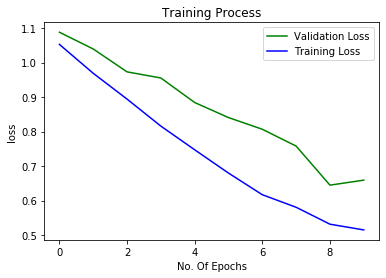

In [84]:
plt.title('Training Process')
dev_axis = np.arange(len(dev_loss))
plt.plot(dev_axis,dev_loss,color = 'green', label = 'Validation Loss')
plt.plot(dev_axis,loss_tr, color = 'blue', label = 'Training Loss')
plt.legend()
plt.xlabel('No. Of Epochs')
plt.ylabel('loss')
plt.show()

Compute accuracy, precision, recall and F1-Score:

In [85]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['prediction']) 
            for x,y in zip(test_index,test_label)]

print('Accuracy:', accuracy_score(test_label,preds_te))
print('Precision:', precision_score(test_label,preds_te,average='macro'))
print('Recall:', recall_score(test_label,preds_te,average='macro'))
print('F1-Score:', f1_score(test_label,preds_te,average='macro'))

Accuracy: 0.8075639599555061
Precision: 0.8108084767756784
Recall: 0.807554812337421
F1-Score: 0.8072457678358133


In [102]:
W = network_weights(vocab_size=len(vocab),embedding_dim=150,
                    hidden_dim=[200], num_classes=3)

for i in range(len(W)):
    print('Shape W'+str(i), W[i].shape)

W, loss_tr, dev_loss = SGD(train_index, train_label,
                            W,
                            X_dev=dev_index, 
                            Y_dev=dev_label,
                            lr=0.001, 
                            dropout=0.1,
                            freeze_emb=False,
                            tolerance=0.0001,
                            epochs=100)


Shape W0 (8931, 150)
Shape W1 (150, 200)
Shape W2 (200, 3)
Epoch: 0| Training loss: 0.9409444861888886| Validation loss: 0.987893140766603
Epoch: 1| Training loss: 0.7855594402959003| Validation loss: 0.8697066994124808
Epoch: 2| Training loss: 0.6850670084513787| Validation loss: 0.7854103287560688
Epoch: 3| Training loss: 0.5882717719897269| Validation loss: 0.7099898272696723
Epoch: 4| Training loss: 0.5328107109619072| Validation loss: 0.7395948528862837


#### Plot the learning process

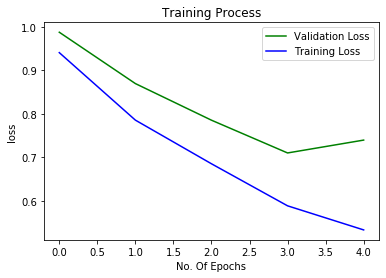

In [103]:
plt.title('Training Process')
dev_axis = np.arange(len(dev_loss))
plt.plot(dev_axis,dev_loss,color = 'green', label = 'Validation Loss')
plt.plot(dev_axis,loss_tr, color = 'blue', label = 'Training Loss')
plt.legend()
plt.xlabel('No. Of Epochs')
plt.ylabel('loss')
plt.show()

#### Compute accuracy,precision,recall and F-1 score

In [104]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['prediction']) 
            for x,y in zip(test_index,test_label)]

print('Accuracy:', accuracy_score(test_label,preds_te))
print('Precision:', precision_score(test_label,preds_te,average='macro'))
print('Recall:', recall_score(test_label,preds_te,average='macro'))
print('F1-Score:', f1_score(test_label,preds_te,average='macro'))

Accuracy: 0.731924360400445
Precision: 0.7360576731130091
Recall: 0.731917502787068
F1-Score: 0.7299041834478786


In [108]:
W = network_weights(vocab_size=len(vocab),embedding_dim=300,
                    hidden_dim=[200], num_classes=3)

for i in range(len(W)):
    print('Shape W'+str(i), W[i].shape)

W, loss_tr, dev_loss = SGD(train_index, train_label,
                            W,
                            X_dev=dev_index, 
                            Y_dev=dev_label,
                            lr=0.001, 
                            dropout=0.3,
                            freeze_emb=False,
                            tolerance=0.0001,
                            epochs=100)


Shape W0 (8931, 300)
Shape W1 (300, 200)
Shape W2 (200, 3)
Epoch: 0| Training loss: 0.8675963342313001| Validation loss: 1.1245162615491129
Epoch: 1| Training loss: 0.7223083825479761| Validation loss: 0.9563252828724554
Epoch: 2| Training loss: 0.6333859907322049| Validation loss: 0.8155210329454422
Epoch: 3| Training loss: 0.5863623282217585| Validation loss: 0.8490600586182523


#### Plot the learning process

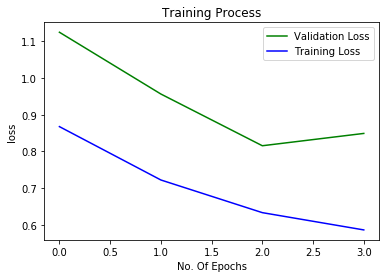

In [110]:
plt.title('Training Process')
dev_axis = np.arange(len(dev_loss))
plt.plot(dev_axis,dev_loss,color = 'green', label = 'Validation Loss')
plt.plot(dev_axis,loss_tr, color = 'blue', label = 'Training Loss')
plt.legend()
plt.xlabel('No. Of Epochs')
plt.ylabel('loss')
plt.show()

#### Compute accuracy,precision,recall and F-1 score

In [109]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['prediction']) 
            for x,y in zip(test_index,test_label)]

print('Accuracy:', accuracy_score(test_label,preds_te))
print('Precision:', precision_score(test_label,preds_te,average='macro'))
print('Recall:', recall_score(test_label,preds_te,average='macro'))
print('F1-Score:', f1_score(test_label,preds_te,average='macro'))

Accuracy: 0.7597330367074527
Precision: 0.7613633760765475
Recall: 0.7597250092902268
F1-Score: 0.7599027673032525


### Performance of different models for different hyperparameters : 

In [130]:
data = {'LR':[0.001,0.001,0.001],'embedding_dim':[50,150,300],'dropout_rate':[0.2,0.1,0.3],'Accuracy':[0.8075,0.7319,0.7597],'Precision':[0.8108,0.7360,0.7613],'Recall':[0.8075,0.7319,0.7597],'F1-Score':[0.8072,0.7299,0.7599],'Training Loss':[0.5316,0.5882,0.6333],'Validation Loss':[0.6448,0.7099,0.8155]}
result = pd.DataFrame(data)
result

,LR,embedding_dim,dropout_rate,Accuracy,Precision,Recall,F1-Score,Training Loss,Validation Loss
0,0.001,50,0.2,0.8075,0.8108,0.8075,0.8072,0.5316,0.6448
1,0.001,150,0.1,0.7319,0.7360,0.7319,0.7299,0.5882,0.7099
2,0.001,300,0.3,0.7597,0.7613,0.7597,0.7599,0.6333,0.8155


After training the model with the above different sets of hyperparameters, the one with learning rate as 0.001, embedding dimensions as 50, dropout rate as 0.2 is performing the best among others as it is giving highest(within the given set) accuracy,precision,recall and F1-score.

# Using Pre-trained Embeddings

Now I've re-trained the network using GloVe pre-trained embeddings. For that, I've to set freeze_emb as True in the `backward_pass` function above to stop computing gradients and updating weights of the embedding matrix.

The function below is used to obtain the embedding martix for the vocabulary.

In [56]:
def get_glove_embeddings(f_zip, f_txt, word2id, emb_size=300):
    
    w_emb = np.zeros((len(word2id), emb_size))
    
    with zipfile.ZipFile(f_zip) as z:
        with z.open(f_txt) as f:
            for line in f:
                line = line.decode('utf-8')
                word = line.split()[0]
                     
                if word in vocab:
                    emb = np.array(line.strip('\n').split()[1:]).astype(np.float32)
                    w_emb[word2id[word]] +=emb
    return w_emb

In [57]:
word2id = vocab_word_to_id
w_glove = get_glove_embeddings("glove.840B.300d.zip","glove.840B.300d.txt",word2id)

First, I initialised the weights of the network using the `network_weights` function. Secondly, I've replaced the weigths of the embedding matrix with `w_glove`. Finally, I've trained the network by freezing the embedding weights: 

In [122]:
W = network_weights(vocab_size=len(vocab),embedding_dim=300,
                    hidden_dim=[200], num_classes=3)
W[0] = w_glove

for i in range(len(W)):
    print('Shape W'+str(i), W[i].shape)

W, loss_tr, dev_loss = SGD(train_index, train_label,
                            W,
                            X_dev=dev_index, 
                            Y_dev=dev_label,
                            lr=0.001, 
                            dropout=0.2,
                            freeze_emb=True,
                            tolerance=0.0001,
                            epochs=100)


Shape W0 (8931, 300)
Shape W1 (300, 200)
Shape W2 (200, 3)
Epoch: 0| Training loss: 0.5737318446961233| Validation loss: 0.4896115769905286
Epoch: 1| Training loss: 0.573083436809407| Validation loss: 0.3875940248102376
Epoch: 2| Training loss: 0.5743699924446178| Validation loss: 0.35815563029462405
Epoch: 3| Training loss: 0.6223966066716771| Validation loss: 0.3901267323324869


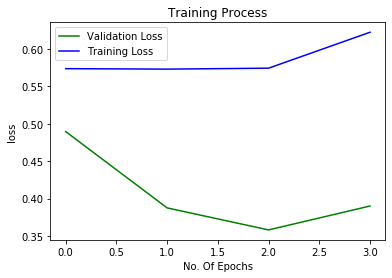

In [123]:
plt.title('Training Process')
dev_axis = np.arange(len(dev_loss))
plt.plot(dev_axis,dev_loss,color = 'green', label = 'Validation Loss')
plt.plot(dev_axis,loss_tr, color = 'blue', label = 'Training Loss')
plt.legend()
plt.xlabel('No. Of Epochs')
plt.ylabel('loss')
plt.show()

In [124]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['prediction']) 
            for x,y in zip(test_index,test_label)]

print('Accuracy:', accuracy_score(test_label,preds_te))
print('Precision:', precision_score(test_label,preds_te,average='macro'))
print('Recall:', recall_score(test_label,preds_te,average='macro'))
print('F1-Score:', f1_score(test_label,preds_te,average='macro'))

Accuracy: 0.8754171301446051
Precision: 0.8755743461898561
Recall: 0.8753808992939428
F1-Score: 0.875432061478573


In [79]:
W = network_weights(vocab_size=len(vocab),embedding_dim=300,
                    hidden_dim=[200], num_classes=3)
W[0] = w_glove

for i in range(len(W)):
    print('Shape W'+str(i), W[i].shape)

W, loss_tr, dev_loss = SGD(train_index, train_label,
                            W,
                            X_dev=dev_index, 
                            Y_dev=dev_label,
                            lr=0.0001, 
                            dropout=0.2,
                            freeze_emb=True,
                            tolerance=0.0001,
                            epochs=100)


Shape W0 (8931, 300)
Shape W1 (300, 200)
Shape W2 (200, 3)
Epoch: 0| Training loss: 0.9801620631190886| Validation loss: 1.0466986881139344
Epoch: 1| Training loss: 0.8272700903463225| Validation loss: 0.8237288521729912
Epoch: 2| Training loss: 0.7227701777049441| Validation loss: 0.6650966186065752
Epoch: 3| Training loss: 0.6750257504283506| Validation loss: 0.6088741879917218
Epoch: 4| Training loss: 0.6455921368438627| Validation loss: 0.5781292776066606
Epoch: 5| Training loss: 0.6123908379542802| Validation loss: 0.5701115911793649
Epoch: 6| Training loss: 0.602893958559782| Validation loss: 0.5639982492546132
Epoch: 7| Training loss: 0.5977755175200858| Validation loss: 0.4729173218356345
Epoch: 8| Training loss: 0.5674544459238305| Validation loss: 0.47993848768195235


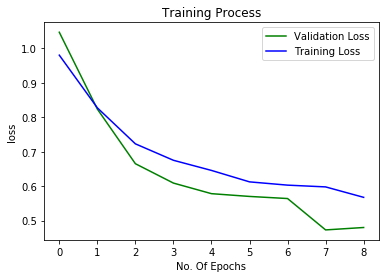

In [81]:
plt.title('Training Process')
dev_axis = np.arange(len(dev_loss))
plt.plot(dev_axis,dev_loss,color = 'green', label = 'Validation Loss')
plt.plot(dev_axis,loss_tr, color = 'blue', label = 'Training Loss')
plt.legend()
plt.xlabel('No. Of Epochs')
plt.ylabel('loss')
plt.show()

In [82]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['prediction']) 
            for x,y in zip(test_index,test_label)]

print('Accuracy:', accuracy_score(test_label,preds_te))
print('Precision:', precision_score(test_label,preds_te,average='macro'))
print('Recall:', recall_score(test_label,preds_te,average='macro'))
print('F1-Score:', f1_score(test_label,preds_te,average='macro'))

Accuracy: 0.8097886540600667
Precision: 0.8103704206751812
Recall: 0.8097621701969527
F1-Score: 0.8096448233856918


In [126]:
W = network_weights(vocab_size=len(vocab),embedding_dim=300,
                    hidden_dim=[200], num_classes=3)
W[0] = w_glove

for i in range(len(W)):
    print('Shape W'+str(i), W[i].shape)

W, loss_tr, dev_loss = SGD(train_index, train_label,
                            W,
                            X_dev=dev_index, 
                            Y_dev=dev_label,
                            lr=0.001, 
                            dropout=0.1,
                            freeze_emb=True,
                            tolerance=0.0001,
                            epochs=100)


Shape W0 (8931, 300)
Shape W1 (300, 200)
Shape W2 (200, 3)
Epoch: 0| Training loss: 0.5168466536545805| Validation loss: 0.4512313858210264
Epoch: 1| Training loss: 0.4724784513368399| Validation loss: 0.33779464342772964
Epoch: 2| Training loss: 0.4432400952621844| Validation loss: 0.30291059847981033
Epoch: 3| Training loss: 0.4481421004673362| Validation loss: 0.2860403955287771
Epoch: 4| Training loss: 0.4564934343287133| Validation loss: 0.26195081950381705
Epoch: 5| Training loss: 0.4484814087384734| Validation loss: 0.25687628889493164
Epoch: 6| Training loss: 0.4684282061388263| Validation loss: 0.33222024473590933


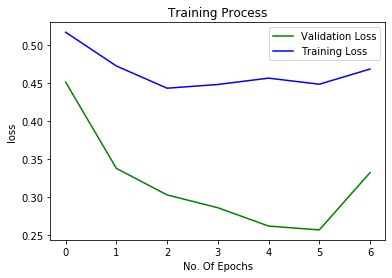

In [128]:
plt.title('Training Process')
dev_axis = np.arange(len(dev_loss))
plt.plot(dev_axis,dev_loss,color = 'green', label = 'Validation Loss')
plt.plot(dev_axis,loss_tr, color = 'blue', label = 'Training Loss')
plt.legend()
plt.xlabel('No. Of Epochs')
plt.ylabel('loss')
plt.show()

In [127]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['prediction']) 
            for x,y in zip(test_index,test_label)]

print('Accuracy:', accuracy_score(test_label,preds_te))
print('Precision:', precision_score(test_label,preds_te,average='macro'))
print('Recall:', recall_score(test_label,preds_te,average='macro'))
print('F1-Score:', f1_score(test_label,preds_te,average='macro'))

Accuracy: 0.8765294771968855
Precision: 0.8781170267432249
Recall: 0.8765143069490895
F1-Score: 0.8769956947511656


### Performance of different models for different hyperparameters (Using Glove or Pre-trained Embeddings): 

In [129]:
data = {'LR':[0.001,0.0001,0.001],'dropout_rate':[0.2,0.2,0.1],'Accuracy':[0.8754,0.8097,0.8765],'Precision':[0.8755,0.8103,0.8781],'Recall':[0.8753,0.8097,0.8765],'F1-Score':[0.8754,0.8096,0.8769],'Training Loss':[0.5743,0.5977,0.4484],'Validation Loss':[0.3581,0.4729,0.2568]}
result = pd.DataFrame(data)
result

,LR,dropout_rate,Accuracy,Precision,Recall,F1-Score,Training Loss,Validation Loss
0,0.0010,0.2,0.8754,0.8755,0.8753,0.8754,0.5743,0.3581
1,0.0001,0.2,0.8097,0.8103,0.8097,0.8096,0.5977,0.4729
2,0.0010,0.1,0.8765,0.8781,0.8765,0.8769,0.4484,0.2568


After training the model with the above different sets of hyperparameters, the one with learning rate as 0.001,dropout rate as 0.1 is performing the best among others as it is giving highest(within the given set) accuracy,precision,recall and F1-score.

## Full Results (For the best model)


| Model | Precision  | Recall  | F1-Score  | Accuracy
|:-:|:-:|:-:|:-:|:-:|
| Average Embedding  | 0.8108  |  0.8075 |  0.8072 | 0.8075  |
| Average Embedding (Pre-trained)  | 0.8781  |  0.8765 | 0.8769   |  0.8765 |

